<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/PredictStockRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [3]:
#import packages
from IPython.display import display
import pandas as pd
import numpy as np

import datetime as dt
import pandas_datareader.data  as pdr

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

sns.set()
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.2)
register_matplotlib_converters()

Using TensorFlow backend.


In [0]:
def build_model(data, training_days, training_itmes):
  dataset = data['Adj Close'].values.reshape(-1, 1)
  train = dataset[0:training_itmes,0]

  #converting dataset into x_train and y_train
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(dataset)

  x_train, y_train = [], []
  for i in range(training_days, len(train)):
      x_train.append(scaled_data[i-training_days:i, 0])
      y_train.append(scaled_data[i, 0])
  x_train, y_train = np.array(x_train), np.array(y_train)

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(units=50))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

  return model, scaler

In [0]:
def predict_price(data, training_days, training_itmes, model, scaler):
  valid = data[training_itmes - training_days:]['Adj Close'].values.reshape(-1, 1)
  inputs  = scaler.transform(valid)

  X_test = []
  for i in range(training_days, inputs.shape[0]):
      X_test.append(inputs[i-training_days:i, 0])
  X_test = np.array(X_test)

  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
  closing_price = model.predict(X_test)
  closing_price = scaler.inverse_transform(closing_price)
  rms = np.sqrt(np.mean(np.power((valid[:,0] - closing_price),2)))
  print("RMSE:{}".format(rms))
  return closing_price  

In [0]:
ticker = "^GSPC"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(365 * 5)
data = pdr.get_data_yahoo(ticker, start_date, end_date) 

In [0]:
training_days = 60
training_itmes = (int)(len(data) * 0.7) 

In [9]:
model, scaler = build_model(data, training_days, training_itmes)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





 - 61s - loss: 0.0017


In [10]:
closing_price = predict_price(data, training_days, training_itmes, model, scaler)

RMSE:246.81174915626278


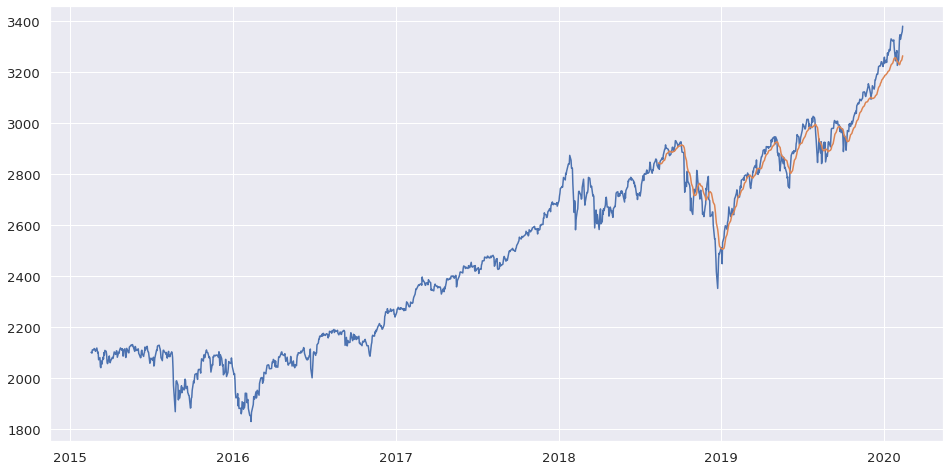

In [11]:
#for plotting
data.loc[training_itmes:, 'Predictions'] = closing_price[:,0]
plt.plot(data[['Adj Close','Predictions']])
plt.show()

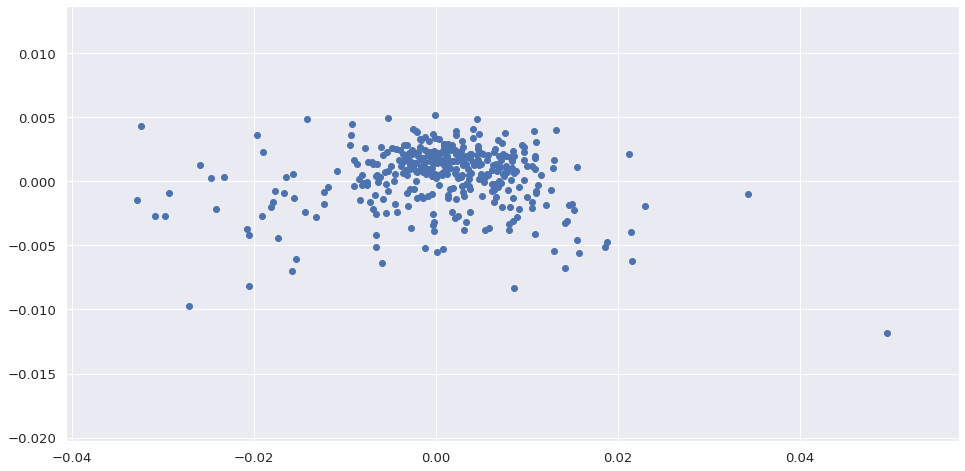

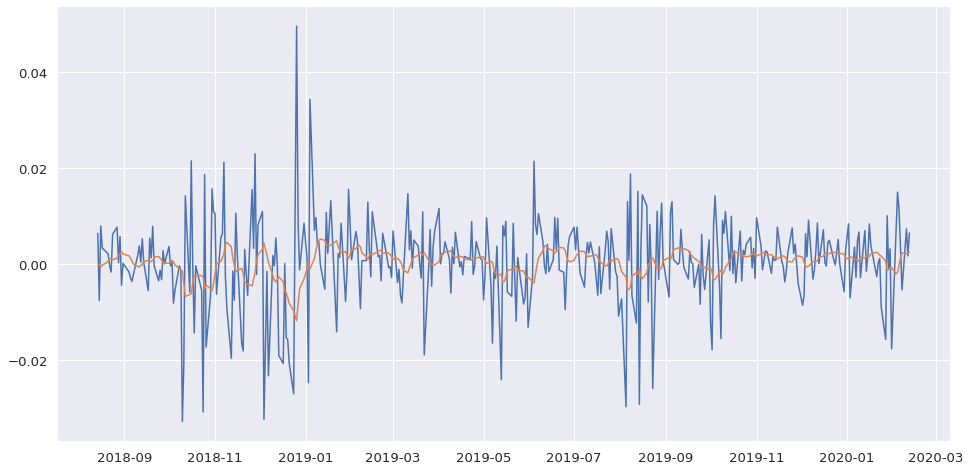

,Adj Close,Predictions,PriceChange,PredChange
Date,,,,
2018-08-14,2839.959961,2842.670654,0.006389,-0.000222
2018-08-15,2818.370117,2842.418213,-0.007602,-0.000089
2018-08-16,2840.689941,2840.506348,0.007919,-0.000673
2018-08-17,2850.129883,2839.827881,0.003323,-0.000239
2018-08-20,2857.050049,2840.542480,0.002428,0.000252
...,...,...,...,...
2020-02-06,3345.780029,3232.629150,0.003326,0.001370
2020-02-07,3327.709961,3240.119385,-0.005401,0.002317
2020-02-10,3352.090088,3246.968018,0.007326,0.002114


In [12]:
prediction = data[['Adj Close', 'Predictions']]
prediction = prediction.dropna()
prediction['PriceChange'] = data['Adj Close'].pct_change()
prediction['PredChange'] = data['Predictions'].pct_change()
prediction = prediction.dropna()
plt.scatter(x=prediction['PriceChange'], y=prediction['PredChange'])
plt.show()
plt.plot(prediction[['PriceChange', 'PredChange']])
plt.show()
display(prediction)
